# Olist E‑Commerce Analytics — Modeling

This notebook builds (1) monthly forecasts for orders and revenue, and (2) a simple classification model to predict satisfied reviews (score ≥ 4) using delivery delay and order features.

In [ ]:
# Imports & settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import skrub

# Forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

## Paths & helpers (works locally & on Kaggle)

In [2]:
KAGGLE = os.path.exists('/kaggle/input')
WORK_DIR = '/kaggle/working' if KAGGLE else '.'
VIS_DIR = os.path.join(WORK_DIR, 'visuals')
os.makedirs(VIS_DIR, exist_ok=True)

def savefig_safe(name, dpi=300):
    path = os.path.join(VIS_DIR, name)
    plt.savefig(path, dpi=dpi, bbox_inches='tight')
    print(f"Saved figure → {path}")

DATA_BASE = '../data' if not KAGGLE else '/kaggle/input'

def find_kaggle_dir(candidates=(
    'olist-brazilian-ecommerce', 'brazilian-ecommerce', 'olist-ecommerce'
)):
    if not KAGGLE:
        return None
    try:
        entries = os.listdir('/kaggle/input')
    except Exception:
        return None
    for cand in candidates:
        for e in entries:
            if cand.lower() in e.lower():
                return os.path.join('/kaggle/input', e)
    return None

KAGGLE_DIR = find_kaggle_dir()
if KAGGLE and KAGGLE_DIR:
    DATA_BASE = KAGGLE_DIR
print('DATA_BASE =', DATA_BASE)

DATA_BASE = ../data


## Load & prepare data (same joins as EDA)

In [ ]:
def p(*names):
    return os.path.join(DATA_BASE, *names)

orders   = pd.read_csv(p('C:/Users/teodo/Desktop/github/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_orders_dataset.csv'))
items    = pd.read_csv(p('C:/Users/teodo/Desktop/github/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_items_dataset.csv'))
payments = pd.read_csv(p('C:/Users/teodo/Desktop/github/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_payments_dataset.csv'))
reviews  = pd.read_csv(p('C:/Users/teodo/Desktop/github/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_reviews_dataset.csv'))
customers= pd.read_csv(p('C:/Users/teodo/Desktop/github/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_customers_dataset.csv'))

# Parse dates
date_cols = [
    'order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
    'order_delivered_customer_date','order_estimated_delivery_date'
] #TURN TO 
for c in date_cols:
    if c in orders.columns:
        orders[c] = pd.to_datetime(orders[c], errors='coerce')
if 'review_creation_date' in reviews.columns:
    reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'], errors='coerce')

# Delivered orders subset
delivered = orders[orders['order_status'].isin(['delivered'])].copy()

# Aggregations
item_agg = items.groupby('order_id', as_index=False).agg(
    revenue=('price', 'sum'),
    freight=('freight_value', 'sum'),
    n_items=('order_item_id','count')
)
pay_agg = payments.groupby('order_id', as_index=False).agg(
    payment_total=('payment_value','sum')
)
rev_sorted = reviews.sort_values('review_creation_date')
rev_latest = rev_sorted.groupby('order_id', as_index=False).tail(1)[['order_id','review_score']]
cust_slim = customers[['customer_id','customer_unique_id','customer_state']].drop_duplicates('customer_id')

ord_base = (delivered
    .merge(item_agg, on='order_id', how='left')
    .merge(pay_agg, on='order_id', how='left')
    .merge(rev_latest, on='order_id', how='left')
    .merge(cust_slim, on='customer_id', how='left')
)
ord_base['total_value'] = ord_base[['revenue','freight']].sum(axis=1)
ord_base['order_month'] = ord_base['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
ord_base.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,revenue,freight,n_items,payment_total,review_score,customer_unique_id,customer_state,total_value,order_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,8.72,1,38.71,4.0,7c396fd4830fd04220f754e42b4e5bff,SP,38.71,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70,22.76,1,141.46,4.0,af07308b275d755c9edb36a90c618231,BA,141.46,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90,19.22,1,179.12,5.0,3a653a41f6f9fc3d2a113cf8398680e8,GO,179.12,2018-08-01


## Part 1 — Monthly forecasting (orders & revenue)

In [4]:
# Build monthly KPIs
kpi = ord_base.groupby('order_month', as_index=False).agg(
    orders=('order_id','nunique'),
    revenue=('total_value','sum')
)

# Ensure a continuous monthly index (fill missing months with zeros)
idx = pd.date_range(kpi['order_month'].min(), kpi['order_month'].max(), freq='MS')
kpi = kpi.set_index('order_month').reindex(idx).fillna(0.0)
kpi.index.name = 'order_month'
kpi.head()

,orders,revenue
order_month,,
2016-09-01,1.0,143.46
2016-10-01,265.0,46490.66
2016-11-01,0.0,0.00
2016-12-01,1.0,19.62
2017-01-01,750.0,127482.37


### Train/test split (last 6 months as test) and SARIMAX fit

c:\Users\teodo\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved figure → C:/Users/teodo/Desktop/github/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/visuals/forecast_orders.png


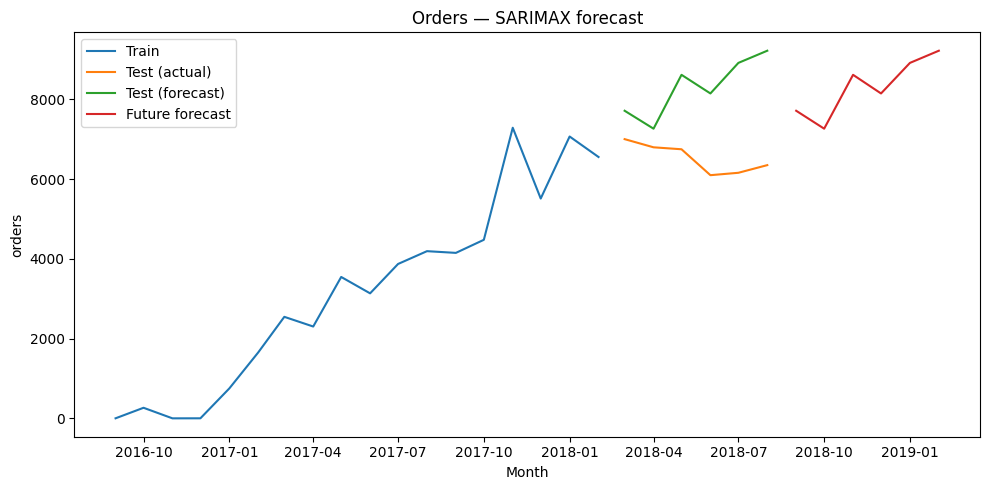

c:\Users\teodo\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved figure → .\visuals\forecast_revenue.png


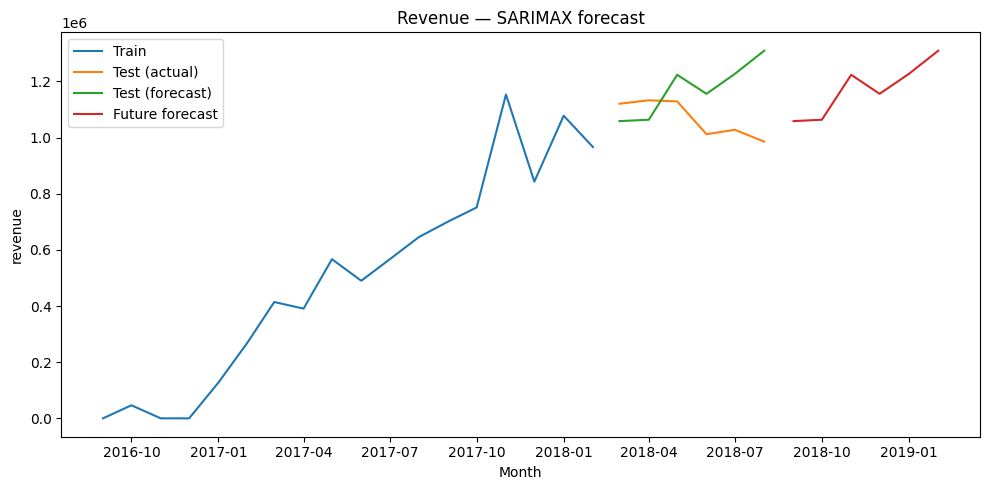

In [6]:
def fit_forecast(series, steps_test=6, steps_ahead=6, title='Forecast', fname='forecast.png'):
    y = series.astype(float)
    split = max(0, len(y) - steps_test)
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    # Default SARIMAX(1,1,1)(1,1,1,12); fall back if convergence fails
    try:
        model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
    except Exception as e:
        print('SARIMAX failed, retrying with simpler order:', e)
        model = SARIMAX(y_train, order=(1,1,0), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)

    # In-sample forecast for test period + out-of-sample
    fc_test = res.get_forecast(steps=len(y_test))
    fc_future = res.get_forecast(steps=steps_ahead)
    pred_test = fc_test.predicted_mean
    pred_future = fc_future.predicted_mean

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(y_train.index, y_train.values, label='Train')
    if len(y_test) > 0:
        plt.plot(y_test.index, y_test.values, label='Test (actual)')
        plt.plot(y_test.index, pred_test.values, label='Test (forecast)')
    # Future horizon dates
    if len(y) > 0:
        last = y.index[-1]
        future_idx = pd.date_range(last + pd.offsets.MonthBegin(1), periods=steps_ahead, freq='MS')
        plt.plot(future_idx, pred_future.values, label='Future forecast')

    plt.title(title)
    plt.xlabel('Month'); plt.ylabel(series.name)
    plt.legend(); plt.tight_layout()
    savefig_safe(fname)
    plt.show()

    return res

_ = fit_forecast(kpi['orders'], title='Orders — SARIMAX forecast', fname='C:/Users/teodo/Desktop/github/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/visuals/forecast_orders.png')
_ = fit_forecast(kpi['revenue'], title='Revenue — SARIMAX forecast', fname='forecast_revenue.png')

## Part 2 — Review satisfaction model (score ≥ 4)

In [7]:
# Build features
feat = ord_base[['order_id','review_score','order_delivered_customer_date','order_estimated_delivery_date',
                 'n_items','revenue','freight','payment_total']].copy()
feat = feat.dropna(subset=['review_score','order_delivered_customer_date','order_estimated_delivery_date'])
feat['delay_days'] = (feat['order_delivered_customer_date'] - feat['order_estimated_delivery_date']).dt.days
feat['total_value'] = feat[['revenue','freight']].sum(axis=1)
feat['freight_share'] = np.where(feat['total_value']>0, feat['freight']/feat['total_value'], 0.0)
feat['satisfied'] = (feat['review_score'] >= 4).astype(int)

X = feat[['delay_days','n_items','total_value','freight_share','payment_total']].fillna(0.0)
y = feat['satisfied']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=200))
])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, proba)
print(f'Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f} | n_test={len(y_test)}')

Accuracy: 0.804 | ROC-AUC: 0.655 | n_test=19165


### Plots: ROC curve & Confusion matrix

Saved figure → .\visuals\roc_review_satisfaction.png


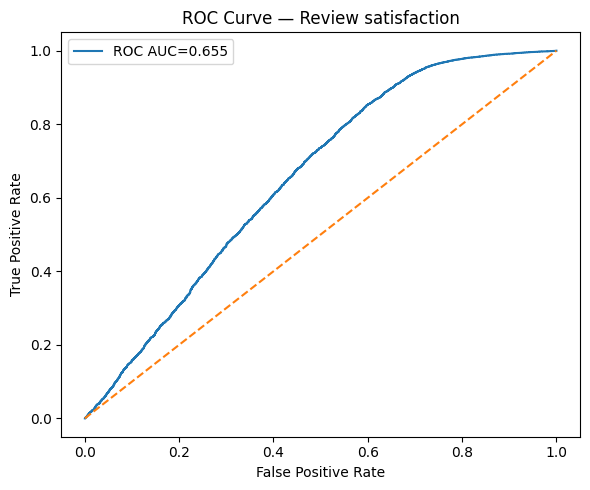

Saved figure → .\visuals\cm_review_satisfaction.png


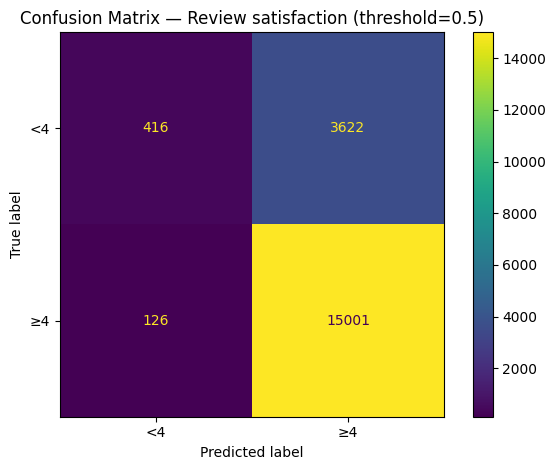

In [8]:
# ROC curve
fpr, tpr, thr = roc_curve(y_test, proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC={auc:.3f}')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Review satisfaction')
plt.legend(); plt.tight_layout()
savefig_safe('roc_review_satisfaction.png')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<4','≥4'])
disp.plot(values_format='d')
plt.title('Confusion Matrix — Review satisfaction (threshold=0.5)')
plt.tight_layout()
savefig_safe('cm_review_satisfaction.png')
plt.show()

### Coefficients (feature effects)

Saved figure → .\visuals\coef_review_satisfaction.png


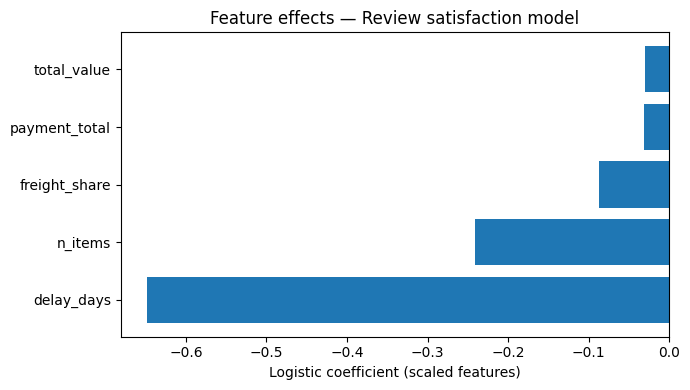

In [9]:
clf = pipe.named_steps['clf']
scaler = pipe.named_steps['scaler']
coefs = pd.DataFrame({
    'feature': X.columns,
    'coef': clf.coef_[0]
}).sort_values('coef', ascending=False)
coefs

plt.figure(figsize=(7,4))
plt.barh(coefs['feature'].iloc[::-1], coefs['coef'].iloc[::-1])
plt.xlabel('Logistic coefficient (scaled features)')
plt.title('Feature effects — Review satisfaction model')
plt.tight_layout()
savefig_safe('coef_review_satisfaction.png')
plt.show()

## Notes
- Forecasts are baseline SARIMAX with default orders; tune seasonality and parameters if needed.
- The review model uses simple numeric features; you can add category/state/seller one‑hots for improved performance.
- All figures are saved under `visuals/` for reporting.